# Predict Job failures in advance

## Data 
https://www.kaggle.com/datasets/skylarkphantom/mit-datacenter-challenge-data


**About Dataset**
TDatacenter monitoring systems offer a variety of data streams and events. The Datacenter Challenge datasets are a combination of high-level data (e.g. Slurm Workload Manager scheduler data) and low-level job-specific time series data. The high-level data includes parameters such as the number of nodes requested, number of CPU/GPU/memory requests, exit codes, and run time data. The low-level time series data is collected on the order of seconds for each job. This granular time series data includes CPU/GPU/memory utilization, amount of disk I/O, and environmental parameters such as power drawn and temperature. Ideally, leveraging both high-level scheduler data and low-level time series data will facilitate the development of AI/ML algorithms which not only predict/detect failures, but also allow for the accurate determination of their cause.

## Citation:
S. Samsi et al., "The MIT Supercloud Dataset," 2021 IEEE High Performance Extreme Computing Conference (HPEC), Waltham, MA, USA, 2021, pp. 1-8, doi: 10.1109/HPEC49654.2021.9622850.
Samsi, Siddharth, Weiss, Matthew, Bestor, David, et al. "The MIT Supercloud Dataset." 2021 IEEE High Performance Extreme Computing Conference (HPEC). IEEE, 2021.


# Import Libraries

In [596]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,9)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectFromModel
import time
#from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import set_config, tree
set_config(display="diagram")
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [598]:
hl_df = pd.read_csv('data/scheduler_data.csv') # High level data

In [599]:
hl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287173 entries, 0 to 287172
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id_array_job        287173 non-null  int64  
 1   id_array_task       287173 non-null  int64  
 2   id_user             287173 non-null  int64  
 3   kill_requid         287173 non-null  int64  
 4   nodes_alloc         287173 non-null  int64  
 5   nodelist            287173 non-null  object 
 6   cpus_req            287173 non-null  int64  
 7   derived_ec          287173 non-null  int64  
 8   exit_code           287173 non-null  int64  
 9   gres_req            216676 non-null  object 
 10  gres_alloc          216676 non-null  object 
 11  gres_used           0 non-null       float64
 12  array_max_tasks     287173 non-null  int64  
 13  array_task_pending  287173 non-null  int64  
 14  constraints         287173 non-null  object 
 15  flags               287173 non-nul

In [600]:
hl_df.head()

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,time_submit,time_eligible,time_start,time_end,time_suspended,track_steps,tres_alloc,tres_req,job_type,id_job
0,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,3014,3014,3014,3014,-1,0,NaN,"1=1,2=5000,4=1,5=1,1002=2",OTHER,13715936505
1,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,3022,3022,3022,3025,-1,0,"1=1,2=9600,4=1,5=1,1002=2","1=1,2=9600,4=1,5=1,1002=2",OTHER,25780056187
2,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,5682,5682,5683,5684,-1,0,"1=4,2=38400,4=1,5=4,1002=1","1=4,2=38400,4=1,5=4,1002=1",OTHER,53722449986
3,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,34467,34467,34468,34548,-1,0,"1=4,2=20000,4=1,5=4,1002=1","1=4,2=20000,4=1,5=4,1002=1",OTHER,19989272070
4,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,34596,34596,34596,35108,-1,0,"1=4,2=20000,4=1,5=4,1002=1","1=4,2=20000,4=1,5=4,1002=1",OTHER,49220239266


In [601]:
ll_df = pd.read_csv('data/dcgm.csv') # Low level data
ll_df.info()
ll_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96893 entries, 0 to 96892
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Node                           96893 non-null  object 
 1   avgmemoryutilization_pct       96893 non-null  float64
 2   avgsmutilization_pct           96893 non-null  float64
 3   energyconsumed_joules          96893 non-null  float64
 4   gpu_id                         96893 non-null  int64  
 5   maxgpumemoryused_bytes         96893 non-null  float64
 6   memoryutilization_pct_avg      96893 non-null  float64
 7   memoryutilization_pct_max      96893 non-null  float64
 8   memoryutilization_pct_min      96893 non-null  float64
 9   pcierxbandwidth_megabytes_avg  96893 non-null  float64
 10  pcierxbandwidth_megabytes_max  96893 non-null  float64
 11  pcierxbandwidth_megabytes_min  96893 non-null  float64
 12  pcietxbandwidth_megabytes_avg  96893 non-null 

,Node,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,...,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job
0,r9170217-n750018,0.0,1.0,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,...,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47,4393785332
1,r44132-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54,18177101425
2,r5354770-n172107,0.0,3.0,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,...,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30,39529488078
3,r1900814-n772143,0.0,0.0,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,...,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72,19994333952
4,r9515777-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,...,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99,397881706


### Data Exploration (low level DGCM Data)

In [602]:
ll_df.isna().mean()

Node                             0.0
avgmemoryutilization_pct         0.0
avgsmutilization_pct             0.0
energyconsumed_joules            0.0
gpu_id                           0.0
maxgpumemoryused_bytes           0.0
memoryutilization_pct_avg        0.0
memoryutilization_pct_max        0.0
memoryutilization_pct_min        0.0
pcierxbandwidth_megabytes_avg    0.0
pcierxbandwidth_megabytes_max    0.0
pcierxbandwidth_megabytes_min    0.0
pcietxbandwidth_megabytes_avg    0.0
pcietxbandwidth_megabytes_max    0.0
pcietxbandwidth_megabytes_min    0.0
powerusage_watts_avg             0.0
powerusage_watts_max             0.0
powerusage_watts_min             0.0
smutilization_pct_avg            0.0
smutilization_pct_max            0.0
smutilization_pct_min            0.0
totalexecutiontime_sec           0.0
id_job                           0.0
dtype: float64

In [603]:
sum(ll_df.duplicated())

0

#### BiVariate Analysis

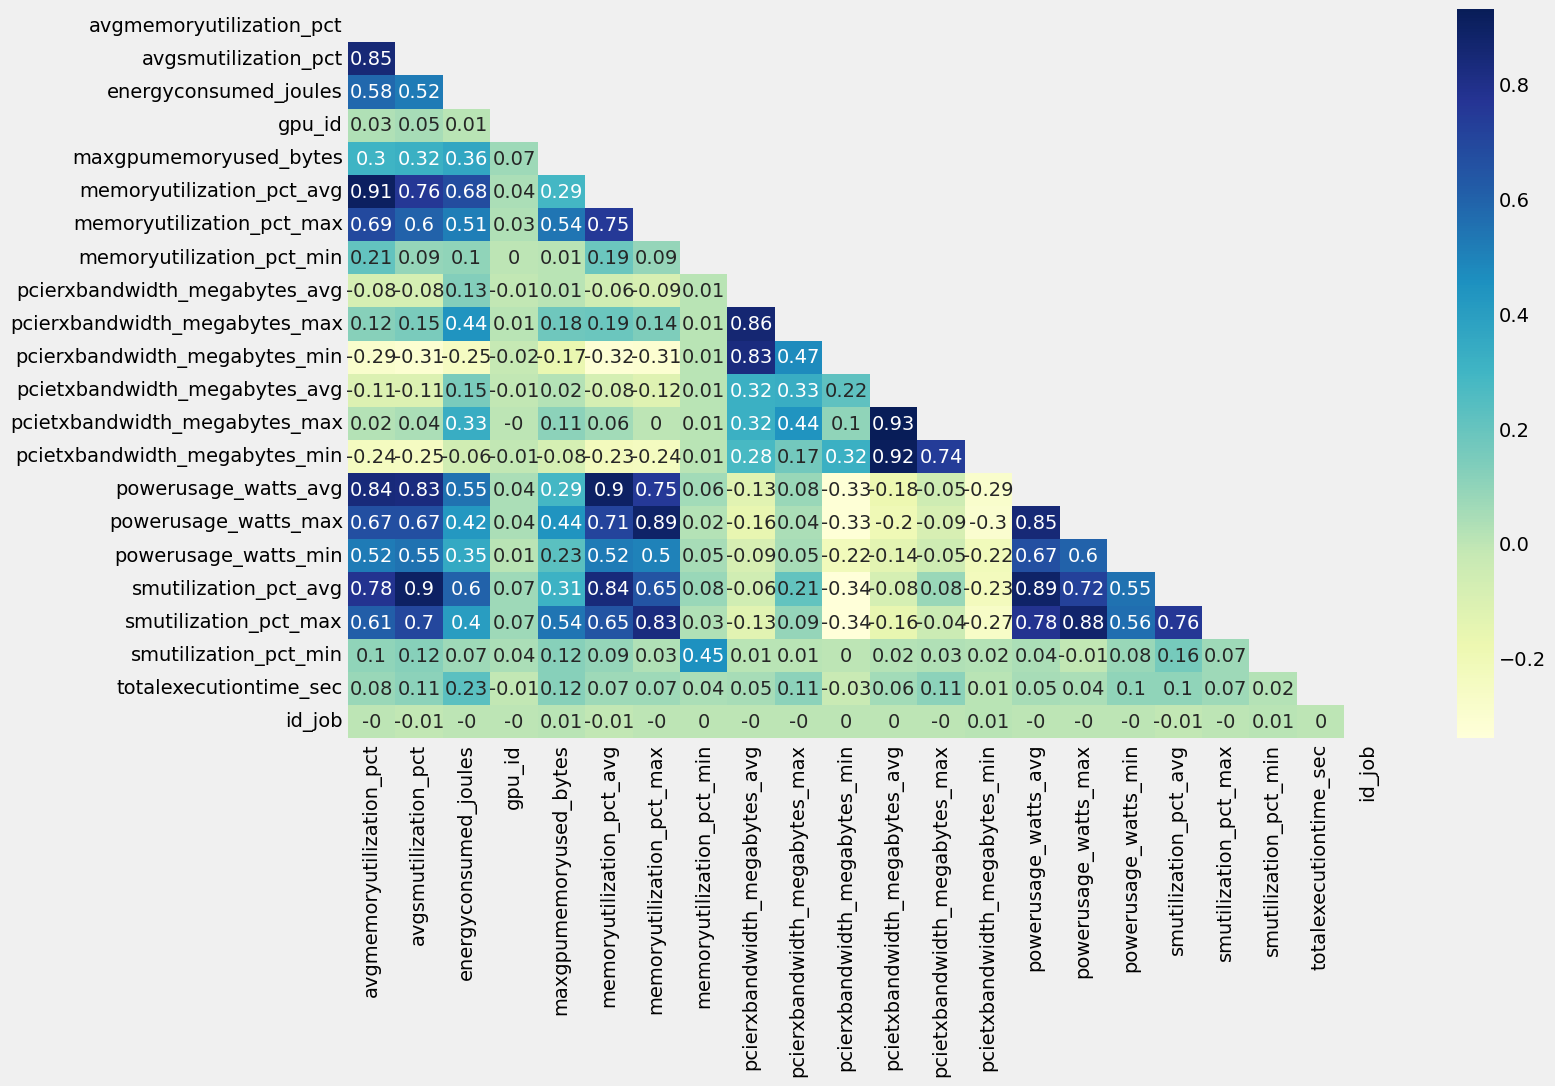

In [604]:
mask = np.triu(np.ones_like(ll_df.corr().round(2)))
sns.heatmap(ll_df.corr().round(2), annot=True, mask=mask, cmap="YlGnBu");

#### Drop Columns with very high correlation

In [ ]:
## Find columns that has high correlation to each other, 
#then pick the one that has high correlation with output column

In [529]:
## Note down the columns that have high correlations as they will yield the same results: 
#These columns should be dropped
col_to_drop = ['avgmemoryutilization_pct', 'powerusage_watts_avg', 'powerusage_watts_max', 
               'pcietxbandwidth_megabytes_max', 'pcietxbandwidth_megabytes_min', 'avgsmutilization_pct']

ll_mod = ll_df.drop(columns=col_to_drop).copy()

#### Univariate Analysis

In [530]:
ll_mod.describe()

,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job
count,96893.000000,96893.000000,9.689300e+04,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,9.689300e+04,9.689300e+04
mean,98732.099491,0.454140,7.169812e+09,8.819409,21.771820,0.098397,922.292240,1102.159712,744.184967,874.355733,31.547750,24.862436,50.476711,0.400968,2.206985e+04,3.344690e+10
std,168706.020958,0.497895,1.048171e+10,13.520285,25.421592,2.529322,609.972447,738.590877,664.887109,650.611060,9.853968,29.566378,43.824541,5.895888,9.998470e+04,1.943712e+10
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e-02,1.055011e+06
25%,1828.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,369.000000,393.000000,119.000000,248.000000,25.574000,0.000000,0.000000,0.000000,1.562000e+01,1.645700e+10
50%,10234.000000,0.000000,2.106589e+09,1.000000,10.000000,0.000000,948.000000,1092.000000,561.000000,837.000000,27.065000,12.000000,51.000000,0.000000,2.010400e+02,3.381671e+10
75%,133714.000000,1.000000,7.762608e+09,17.000000,43.000000,0.000000,1393.000000,1809.000000,1308.000000,1410.000000,37.495000,48.000000,100.000000,0.000000,5.596680e+03,5.009353e+10
max,868934.000000,1.000000,3.408396e+10,89.000000,100.000000,86.000000,2147.000000,2147.000000,2147.000000,2147.000000,146.989000,100.000000,100.000000,100.000000,2.895390e+06,6.710872e+10


In [531]:
#since the number of features are large, the above table is masking some
#ll_df.iloc[:,0:10 ].describe()
#ll_df.iloc[:,10:23 ].describe()

## Data Exploration (High level Schedular data) 

In [532]:
hl_df.isna().mean()

id_array_job          0.000000
id_array_task         0.000000
id_user               0.000000
kill_requid           0.000000
nodes_alloc           0.000000
nodelist              0.000000
cpus_req              0.000000
derived_ec            0.000000
exit_code             0.000000
gres_req              0.245486
gres_alloc            0.245486
gres_used             1.000000
array_max_tasks       0.000000
array_task_pending    0.000000
constraints           0.000000
flags                 0.000000
mem_req               0.000000
partition             0.000000
priority              0.000000
state                 0.000000
timelimit             0.000000
time_submit           0.000000
time_eligible         0.000000
time_start            0.000000
time_end              0.000000
time_suspended        0.000000
track_steps           0.000000
tres_alloc            0.245577
tres_req              0.000000
job_type              0.000000
id_job                0.000000
dtype: float64

In [533]:
hl_df.gres_used.unique()

array([nan])

In [534]:
# drop the columns that has all NaNs
hl_col_to_drop = ['gres_used']

In [535]:
hl_df.duplicated().sum()

0

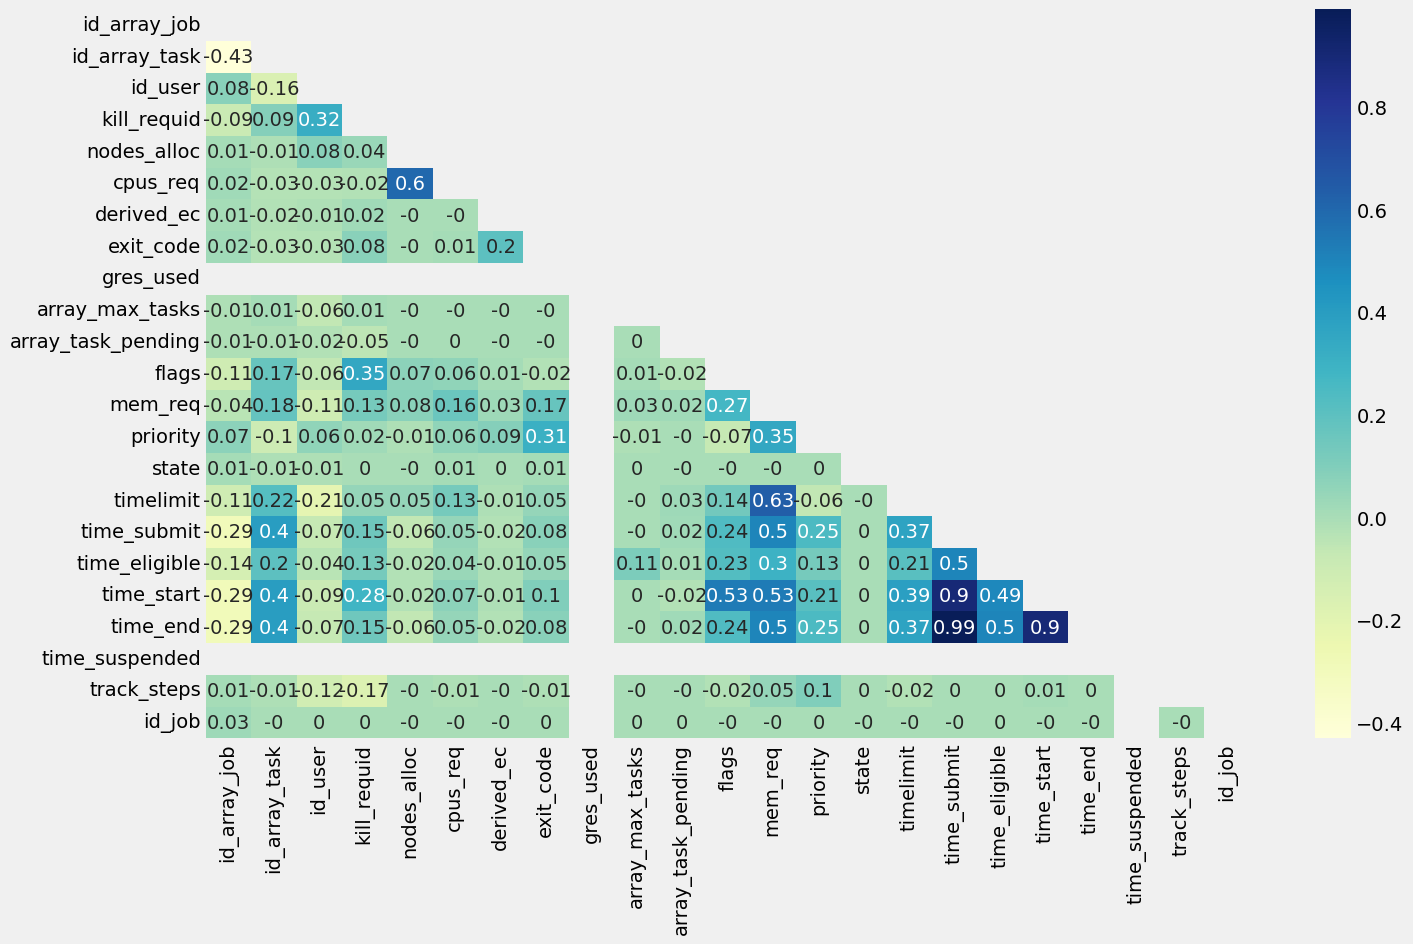

In [536]:
mask = np.triu(np.ones_like(hl_df.corr().round(2)))
sns.heatmap(hl_df.corr().round(2), annot=True, mask=mask, cmap="YlGnBu");

In [537]:
# Since there is very high correlation between time_start, time_end and time_submit, lets explore it
hl_df[['time_start', 'time_end', 'time_submit']]

,time_start,time_end,time_submit
0,3014,3014,3014
1,3022,3025,3022
2,5683,5684,5682
3,34468,34548,34467
4,34596,35108,34596
...,...,...,...
287168,32000935,32000955,32000935
287169,32001024,32001040,32001024
287170,32001104,-1,32001104
287171,32001410,-1,32001410


In [538]:
# drop column time_submit
hl_col_to_drop.append('time_submit')
print(hl_col_to_drop)

['gres_used', 'time_submit']


In [539]:
# inspect time_suspended as the row seems empty in heatmap
hl_df.time_suspended.unique()

array([-1])

In [540]:
#drop the above column 
hl_col_to_drop.append('time_suspended')
print(hl_col_to_drop)

['gres_used', 'time_submit', 'time_suspended']


In [541]:
hl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287173 entries, 0 to 287172
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id_array_job        287173 non-null  int64  
 1   id_array_task       287173 non-null  int64  
 2   id_user             287173 non-null  int64  
 3   kill_requid         287173 non-null  int64  
 4   nodes_alloc         287173 non-null  int64  
 5   nodelist            287173 non-null  object 
 6   cpus_req            287173 non-null  int64  
 7   derived_ec          287173 non-null  int64  
 8   exit_code           287173 non-null  int64  
 9   gres_req            216676 non-null  object 
 10  gres_alloc          216676 non-null  object 
 11  gres_used           0 non-null       float64
 12  array_max_tasks     287173 non-null  int64  
 13  array_task_pending  287173 non-null  int64  
 14  constraints         287173 non-null  object 
 15  flags               287173 non-nul

In [542]:
hl_df.exit_code.unique()

array([  256,     0, 32512,   768, 59648,   512, 33280, 35072,  8960,
        2304, 35584,   253, 32256, 34304, 65280, 32768,  2048,  4608,
        3328,     9, 33024, 15104, 34816,  1024,  1792, 34560, 37888,
       30720, 65024, 33792,  5120, 31744, 59392, 61952, 33536,    15])

In [543]:
hl_df.state.unique()

array([   5,    3,    4,    6,    7,   11, 1024,    1,    0])

In [544]:
hl_df.gres_req.unique()

array([nan, 'gpu:volta:2', 'gpu:volta:1', 'gpu:volta:870',
       'gpu:volta:800', 'gpu:volta:4', 'gpu:volta:16', 'gpu:volta:8',
       'gpu:volta:64', 'gpu:volta:32', 'gpu:volta:128', 'gpu:volta:256',
       'gpu:volta:768', 'gpu:volta:512', 'gpu:volta:6', 'gpu:volta:856',
       'gpu:volta:864', 'gpu:volta:832', 'gpu:volta:680', 'gpu:volta:640',
       'gpu:volta:600', 'gpu:volta:560', 'gpu:volta:540', 'gpu:volta:520',
       'gpu:volta:830', 'gpu:volta:850', 'gpu:volta:48', 'gpu:volta:12',
       'gpu:volta:24', 'gpu:volta:20', 'gpu:volta:28', 'gpu:2', 'gpu:1',
       'gpu:volta:150', 'gpu:volta:786', 'gpu:volta:700', 'gpu:volta:58',
       'gpu:volta:5', 'gpu:volta:696', 'gpu:volta:3', 'gpu:volta:192',
       'gpu:volta:130', 'gpu:4', 'gpu:volta:252', 'gpu:32',
       'gpu:volta:10', 'gpu:16', 'gpu:8', 'gpu:volta:14', 'gpu:3',
       'gpu:12', 'gpu:64'], dtype=object)

In [545]:
hl_df['flags'].unique()

array([ 0,  2,  4,  8, 12])

In [546]:
hl_df.describe(include='O')

,nodelist,gres_req,gres_alloc,constraints,partition,tres_alloc,tres_req,job_type
count,287173,216676,216676,287173,287173,216650,287173,287173
unique,2187,51,42,4,5,595,622,4
top,[],gpu:volta:1,gpu:1,xeon-g6,gpu,"1=1,2=10240,4=1,5=1,1001=1","1=1,2=10240,4=1,5=1,1001=1",OTHER
freq,70525,95687,185261,283084,141342,75430,129274,238887


In [547]:
hl_df.tres_alloc.unique()

array([nan, '1=1,2=9600,4=1,5=1,1002=2', '1=4,2=38400,4=1,5=4,1002=1',
       '1=4,2=20000,4=1,5=4,1002=1', '1=40,2=384000,4=1,5=40,1002=2',
       '1=4,2=38400,4=1,5=4,1002=2', '1=2,2=19200,4=1,5=2,1002=2',
       '1=2,2=19200,3=18446744073709551614,4=1,5=2,1002=2',
       '1=870,2=8352000,4=435,5=870,1002=870',
       '1=800,2=7680000,4=400,5=800,1002=800',
       '1=4,2=38400,4=2,5=4,1002=4', '1=16,2=153600,4=8,5=16,1002=16',
       '1=8,2=76800,4=4,5=8,1002=8', '1=64,2=614400,4=32,5=64,1002=64',
       '1=32,2=307200,4=16,5=32,1002=32',
       '1=128,2=1228800,4=64,5=128,1002=128',
       '1=256,2=2457600,4=128,5=256,1002=256',
       '1=768,2=7372800,4=384,5=768,1002=768',
       '1=512,2=4915200,4=256,5=512,1002=512',
       '1=1,2=5000,4=1,5=1,1002=1', '1=8,2=40000,4=1,5=8,1002=1',
       '1=1,2=5000,3=18446744073709551614,4=1,5=1,1002=2',
       '1=12,2=60000,4=1,5=12,1002=1', '1=2,2=19200,4=2,5=2,1002=2',
       '1=28,2=140000,4=1,5=28,1002=1', '1=28,2=140000,4=1,5=28,1002=2',

In [548]:
#Drop the columns with complicated values and high unique numbers
hl_col_to_drop.append('tres_alloc')
hl_col_to_drop.append('tres_req')
print(hl_col_to_drop)

['gres_used', 'time_submit', 'time_suspended', 'tres_alloc', 'tres_req']


In [549]:
hl_df.drop(hl_col_to_drop, inplace=True, axis=1)
print(hl_df.info())
hl_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287173 entries, 0 to 287172
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id_array_job        287173 non-null  int64 
 1   id_array_task       287173 non-null  int64 
 2   id_user             287173 non-null  int64 
 3   kill_requid         287173 non-null  int64 
 4   nodes_alloc         287173 non-null  int64 
 5   nodelist            287173 non-null  object
 6   cpus_req            287173 non-null  int64 
 7   derived_ec          287173 non-null  int64 
 8   exit_code           287173 non-null  int64 
 9   gres_req            216676 non-null  object
 10  gres_alloc          216676 non-null  object
 11  array_max_tasks     287173 non-null  int64 
 12  array_task_pending  287173 non-null  int64 
 13  constraints         287173 non-null  object
 14  flags               287173 non-null  int64 
 15  mem_req             287173 non-null  uint64
 16  pa

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,partition,priority,state,timelimit,time_eligible,time_start,time_end,track_steps,job_type,id_job
0,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,gpu,19995,5,720,3014,3014,3014,0,OTHER,13715936505
1,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,gaia,19995,3,4294967295,3022,3022,3025,0,OTHER,25780056187
2,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,gaia,110012,5,4294967295,5682,5683,5684,0,OTHER,53722449986
3,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,gpu,110023,4,720,34467,34468,34548,0,OTHER,19989272070
4,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,gpu,110006,4,720,34596,34596,35108,0,OTHER,49220239266


In [550]:
hl_df.job_type.unique()

array(['OTHER', 'LLSUB:INTERACTIVE', 'LLSUB:BATCH', 'LLMAPREDUCE:MAP'],
      dtype=object)

# Merge the 2 DataFrames

## id_job is the common field in both the databases, hence will be used for joining the DataFrames

### Explore id_job column in both DFs

In [551]:
print(hl_df.shape)
hl_df.id_job.nunique()


(287173, 26)


287069

## find and drop the duplicates
**Process Logic: 1) find "all" the Duplicates of the columns id_job.  2) keep only the Failed job, as that is more importatnt for our problem statement**

In [552]:
#find the duplicates
hl_dup_ids = hl_df.loc[hl_df['id_job'].duplicated(keep=False)][['id_job', 'state']]
print(hl_dup_ids.shape) # should be 28173-287069

#Keep only the failed jobs
print(len(hl_dup_ids.index[hl_dup_ids['state'] != 3].tolist()))
hl_df = hl_df.drop(hl_dup_ids.index[hl_dup_ids['state'] != 3].tolist())
print(hl_df.shape)
print(hl_df.id_job.nunique())

(194, 2)
163
(287010, 26)
287010


In [553]:
hl_df.set_index('id_job')

,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,...,mem_req,partition,priority,state,timelimit,time_eligible,time_start,time_end,track_steps,job_type
id_job,,,,,,,,,,,,,,,,,,,,,
13715936505,41161693674,4595979483,66088413977,51671871839,0,[],1,0,256,NaN,...,9223372036854780808,gpu,19995,5,720,3014,3014,3014,0,OTHER
25780056187,41161693674,4595979483,66088413977,51671871839,1,['r2684277-n303509'],1,0,0,gpu:volta:2,...,9223372036854785408,gaia,19995,3,4294967295,3022,3022,3025,0,OTHER
53722449986,41161693674,4595979483,16176946191,51671871839,1,['r5198790-n347934'],4,32512,32512,gpu:volta:1,...,9223372036854785408,gaia,110012,5,4294967295,5682,5683,5684,0,OTHER
19989272070,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,9223372036854780808,gpu,110023,4,720,34467,34468,34548,0,OTHER
49220239266,41161693674,4595979483,16176946191,16176946191,1,['r3541344-n655125'],4,0,0,gpu:volta:1,...,9223372036854780808,gpu,110006,4,720,34596,34596,35108,0,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345742021,41161693674,4595979483,25399748967,51671871839,1,['r810901-n172107'],40,0,256,gpu:volta:1,...,9223372036854784308,normal,110454,5,4294967295,32000935,32000935,32000955,0,OTHER
47595151481,41161693674,4595979483,35441973637,51671871839,1,['r810901-n172107'],1,0,33280,gpu:volta:1,...,9223372036854784308,normal,110061,5,1440,32001024,32001024,32001040,0,LLSUB:INTERACTIVE
41166593563,41161693674,4595979483,38723761107,51671871839,1,['r810901-n172107'],1,0,0,gpu:volta:1,...,9223372036854784308,normal,110600,1,1440,32001104,32001104,-1,0,OTHER


In [554]:
print(ll_mod.shape)
ll_mod.id_job.nunique()

(96893, 17)


74849

In [555]:
ll_mod.set_index('id_job')

,Node,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
id_job,,,,,,,,,,,,,,,,
4393785332,r9170217-n750018,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,1748.0,1613.0,971.0,25.468,11.0,64.0,0.0,4452.47
18177101425,r44132-n469339,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.54
39529488078,r5354770-n172107,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,1849.0,1838.0,1785.0,25.979,6.0,43.0,0.0,8398.30
19994333952,r1900814-n772143,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,542.0,536.0,314.0,26.676,1.0,25.0,0.0,1851.72
397881706,r9515777-n469339,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,1991.0,1991.0,1109.0,25.032,0.0,0.0,0.0,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19023940853,r8141575-n469339,1007.0,0,0.000000e+00,0.0,0.0,0.0,228.0,228.0,228.0,145.0,25.693,0.0,0.0,0.0,39.94
64323977349,r974863-n303766,28046.0,0,1.173357e+09,0.0,0.0,0.0,1809.0,1810.0,1808.0,1589.0,25.664,0.0,9.0,0.0,1072.84
4512455793,r2215649-n410412,644399.0,1,3.129265e+10,27.0,37.0,0.0,1937.0,1972.0,1902.0,942.0,53.471,99.0,100.0,0.0,25054.80


In [556]:
merged_df = pd.merge(left=ll_mod, right=hl_df, on='id_job', how='inner')
print(merged_df.shape)

(96805, 42)


In [557]:
merged_df.head()

,Node,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,...,mem_req,partition,priority,state,timelimit,time_eligible,time_start,time_end,track_steps,job_type
0,r9170217-n750018,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,1748.0,1613.0,...,9223372036854784308,normal,10509,4,4294967295,26341708,26341708,26346159,0,LLSUB:BATCH
1,r44132-n469339,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,9223372036854784308,normal,10912,3,4294967295,23378740,23378740,23378740,0,OTHER
2,r5354770-n172107,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,1849.0,1838.0,...,9223372036854784308,normal,110935,5,4294967295,23094718,23094718,23103116,0,LLSUB:INTERACTIVE
3,r1900814-n772143,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,542.0,536.0,...,9223372036854784308,normal,10520,4,4294967295,24845442,24845442,24847292,0,LLSUB:BATCH
4,r9515777-n469339,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,1991.0,1991.0,...,9223372036854784308,normal,10912,5,4294967295,23377440,23377440,23377441,0,OTHER


# Cleanup Data on merged_df

In [558]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96805 entries, 0 to 96804
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Node                           96805 non-null  object 
 1   energyconsumed_joules          96805 non-null  float64
 2   gpu_id                         96805 non-null  int64  
 3   maxgpumemoryused_bytes         96805 non-null  float64
 4   memoryutilization_pct_avg      96805 non-null  float64
 5   memoryutilization_pct_max      96805 non-null  float64
 6   memoryutilization_pct_min      96805 non-null  float64
 7   pcierxbandwidth_megabytes_avg  96805 non-null  float64
 8   pcierxbandwidth_megabytes_max  96805 non-null  float64
 9   pcierxbandwidth_megabytes_min  96805 non-null  float64
 10  pcietxbandwidth_megabytes_avg  96805 non-null  float64
 11  powerusage_watts_min           96805 non-null  float64
 12  smutilization_pct_avg          96805 non-null 

In [559]:
merged_df.describe(include='O')

,Node,nodelist,gres_req,gres_alloc,constraints,partition,job_type
count,96805,96805,96805,96805,96805,96805,96805
unique,225,662,21,12,3,3,4
top,r3955005-n172107,['r3955005-n172107'],gpu:volta:1,gpu:1,xeon-g6,normal,OTHER
freq,1151,1147,61177,65010,96179,92211,65076


In [560]:
# Drop columns with high number of unique values, but leaving gres_req as this is importatnt feature to look at
merged_df.drop(['Node', 'nodelist', 'id_array_job'], axis=1, inplace=True, errors='ignore')

<AxesSubplot:>

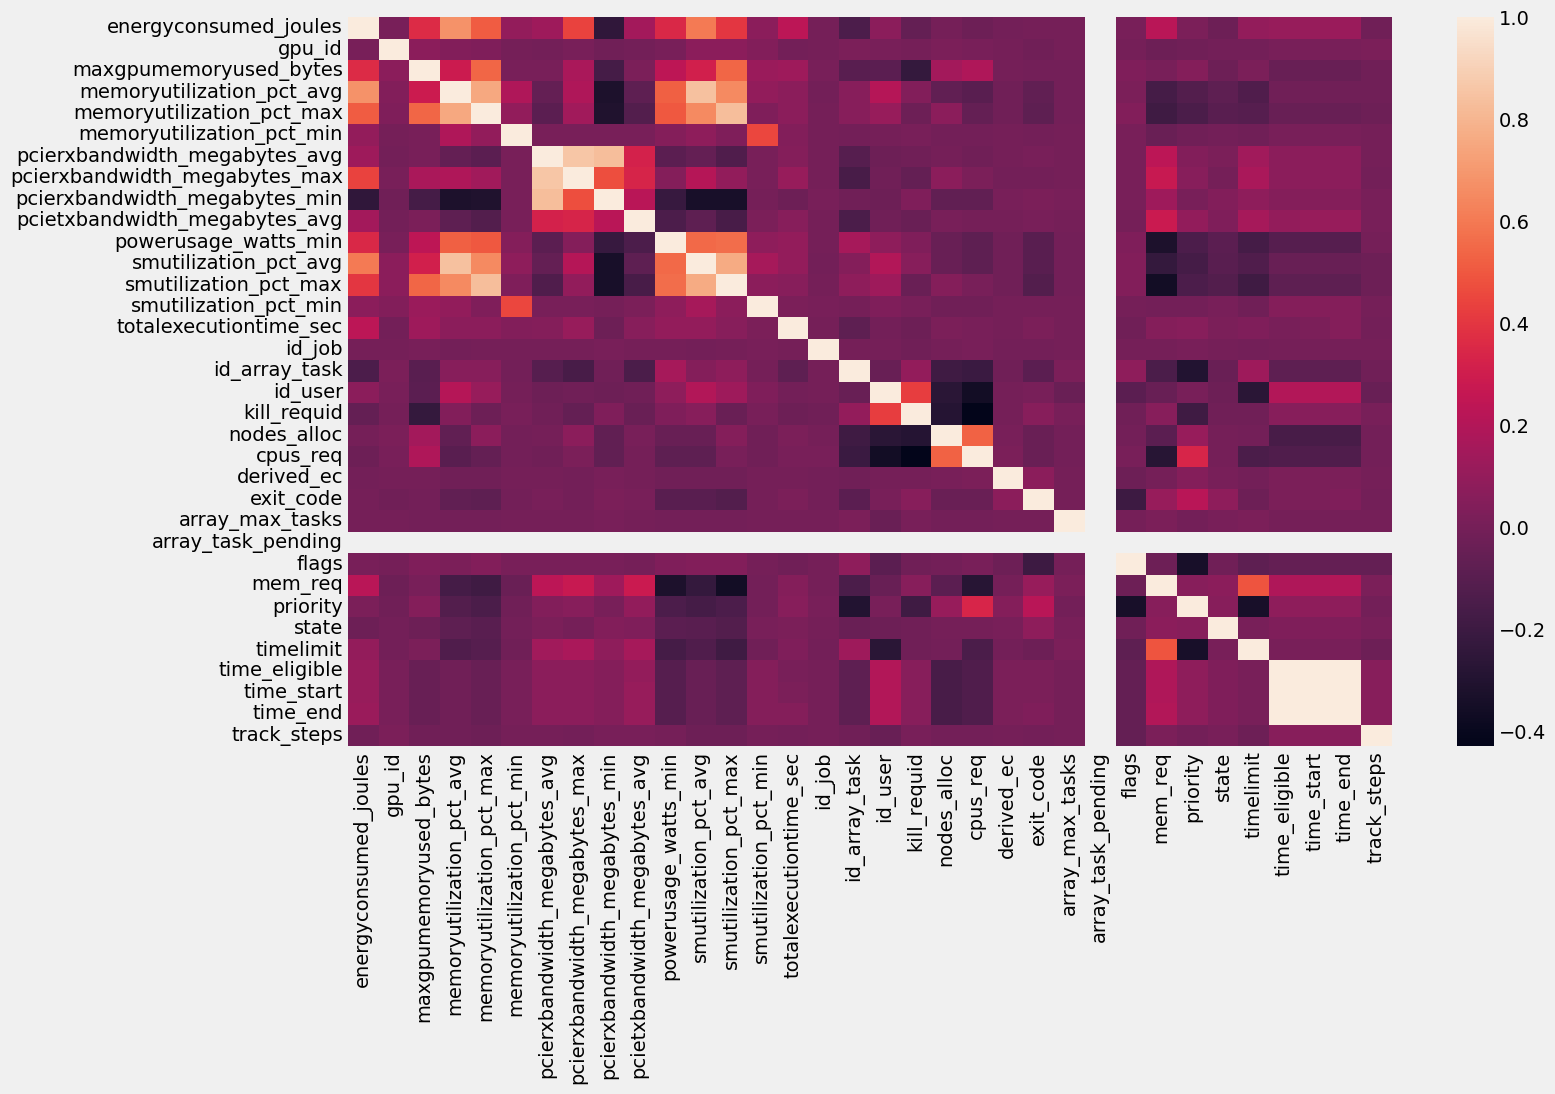

In [561]:
sns.heatmap(merged_df.corr().round(2))


In [562]:
# Drop the columns for array_task pending. also drop the highly correlated columns
merged_cols_to_drop = ['array_task_pending', 'time_eligible', 'pcierxbandwidth_megabytes_max', 
                       'pcierxbandwidth_megabytes_min','smutilization_pct_max','smutilization_pct_min',
                      'memoryutilization_pct_max','memoryutilization_pct_min','smutilization_pct_avg' ]
merged_df.drop(merged_cols_to_drop, axis=1, inplace=True, errors='ignore')

##TODO : Instead of selecting randomly, run a query against the target column 
##and keep the mostly correlted columns to the target

In [563]:
merged_df.head()

,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,pcierxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_avg,powerusage_watts_min,totalexecutiontime_sec,id_job,id_array_task,...,flags,mem_req,partition,priority,state,timelimit,time_start,time_end,track_steps,job_type
0,157521.0,0,2.645557e+09,3.0,1646.0,971.0,25.468,4452.47,4393785332,41161693674,...,4,9223372036854784308,normal,10509,4,4294967295,26341708,26346159,0,LLSUB:BATCH
1,0.0,1,0.000000e+00,0.0,0.0,0.0,0.000,0.54,18177101425,41161693674,...,4,9223372036854784308,normal,10912,3,4294967295,23378740,23378740,0,OTHER
2,94816.0,0,2.917171e+07,0.0,1846.0,1785.0,25.979,8398.30,39529488078,4595979483,...,2,9223372036854784308,normal,110935,5,4294967295,23094718,23103116,0,LLSUB:INTERACTIVE
3,69451.0,0,1.527587e+09,0.0,539.0,314.0,26.676,1851.72,19994333952,9124162775,...,4,9223372036854784308,normal,10520,4,4294967295,24845442,24847292,0,LLSUB:BATCH
4,0.0,1,0.000000e+00,0.0,1991.0,1109.0,25.032,0.99,397881706,10003786564,...,4,9223372036854784308,normal,10912,5,4294967295,23377440,23377441,0,OTHER


In [564]:
merged_df.gres_alloc.value_counts()

gpu:1     65010
gpu:2     16922
gpu:8      5182
gpu:16     4624
gpu:32     2344
gpu:64     1344
gpu:4      1060
gpu:6       102
gpu:10       60
gpu:5        55
gpu:3        54
gpu:12       48
Name: gres_alloc, dtype: int64

In [565]:
merged_df.gres_req.unique()

array(['gpu:volta:1', 'gpu:volta:3', 'gpu:volta:2', 'gpu:1', 'gpu:2',
       'gpu:3', 'gpu:volta:4', 'gpu:volta:8', 'gpu:16', 'gpu:volta:16',
       'gpu:32', 'gpu:4', 'gpu:12', 'gpu:8', 'gpu:volta:10',
       'gpu:volta:6', 'gpu:volta:32', 'gpu:volta:5', 'gpu:volta:64',
       'gpu:volta:12', 'gpu:64'], dtype=object)

### convert gres_alloc and gres_req to int

In [566]:
merged_df['gres_alloc'] = merged_df['gres_alloc'].replace({'gpu:': ''},regex=True)

#gres_req
merged_df['gres_req'] = merged_df['gres_req'].replace({'gpu:': '', 'volta:': ''},regex=True)
print(merged_df.gres_req.unique())
print(merged_df.gres_alloc.unique())

['1' '3' '2' '4' '8' '16' '32' '12' '10' '6' '5' '64']
['1' '3' '2' '4' '8' '16' '32' '12' '10' '6' '5' '64']


In [567]:
merged_df.constraints.value_counts()

xeon-g6         96179
xeon-g6&6248      618
xeon-e5             8
Name: constraints, dtype: int64

### Drop highly skewed column 'constraint'

In [568]:
merged_df.drop(['constraints'], inplace=True, axis=1)

In [569]:
merged_df.describe()

,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,pcierxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_avg,powerusage_watts_min,totalexecutiontime_sec,id_job,id_array_task,...,exit_code,array_max_tasks,flags,mem_req,priority,state,timelimit,time_start,time_end,track_steps
count,96805.000000,96805.000000,9.680500e+04,96805.000000,96805.000000,96805.000000,96805.000000,9.680500e+04,9.680500e+04,9.680500e+04,...,96805.000000,96805.000000,96805.000000,9.680500e+04,96805.000000,96805.000000,9.680500e+04,9.680500e+04,9.680500e+04,96805.000000
mean,98536.860844,0.454119,7.164916e+09,8.814596,922.314891,874.348887,31.546708,2.185590e+04,3.343905e+10,1.675929e+10,...,1404.003533,0.004401,4.142307,6.465459e+18,29469.308693,3.754248,1.806124e+09,2.577706e+07,2.579945e+07,0.001023
std,168537.591356,0.497893,1.047490e+10,13.519873,610.030375,650.736056,9.854760,9.938045e+04,1.943884e+10,1.945687e+10,...,6656.117517,0.180678,1.224988,4.222719e+18,39383.967860,3.412100,2.120166e+09,3.094074e+06,3.095043e+06,0.031963
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,8.000000e-02,1.055011e+06,2.513347e+06,...,0.000000,0.000000,0.000000,8.192000e+03,0.000000,3.000000,1.000000e+00,-1.000000e+00,2.119388e+07,0.000000
25%,1827.000000,0.000000,0.000000e+00,0.000000,369.000000,247.000000,25.573000,1.562000e+01,1.645700e+10,4.595979e+09,...,0.000000,0.000000,4.000000,3.072000e+05,10127.000000,3.000000,1.440000e+03,2.302684e+07,2.307574e+07,0.000000
50%,10179.000000,0.000000,2.106589e+09,1.000000,948.000000,837.000000,27.063000,2.006200e+02,3.381195e+10,4.595979e+09,...,0.000000,0.000000,4.000000,9.223372e+18,10233.000000,3.000000,3.024000e+04,2.500751e+07,2.503157e+07,0.000000
75%,133629.000000,1.000000,7.760511e+09,17.000000,1393.000000,1410.000000,37.495000,5.553700e+03,5.007428e+10,2.735197e+10,...,0.000000,0.000000,4.000000,9.223372e+18,10660.000000,5.000000,4.294967e+09,2.832514e+07,2.837626e+07,0.000000
max,868934.000000,1.000000,3.408396e+10,89.000000,2147.000000,2147.000000,146.989000,2.895390e+06,6.710872e+10,6.710714e+10,...,65280.000000,8.000000,12.000000,9.223372e+18,119999.000000,1024.000000,4.294967e+09,3.200102e+07,3.200104e+07,1.000000


### Drop the columns that are not availbale for new jobs

In [570]:
merged_df.drop(['energyconsumed_joules','maxgpumemoryused_bytes', 'memoryutilization_pct_avg',
                'pcierxbandwidth_megabytes_avg', 'powerusage_watts_min', 'time_start', 'time_end',
               'state'], inplace=True, axis=1)

### Since Exit Code a target column, replace all of the code > 0 to 1, where 0 : Success and 1: Failure

In [571]:
merged_df['exit_code'] = np.where(merged_df['exit_code'] > 0, 1, merged_df['exit_code'])
merged_df.exit_code.unique()

array([0, 1])

## Final Exploration of merged table: confirm the columns and if any further cleanup is required

In [572]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96805 entries, 0 to 96804
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gpu_id                         96805 non-null  int64  
 1   pcietxbandwidth_megabytes_avg  96805 non-null  float64
 2   totalexecutiontime_sec         96805 non-null  float64
 3   id_job                         96805 non-null  int64  
 4   id_array_task                  96805 non-null  int64  
 5   id_user                        96805 non-null  int64  
 6   kill_requid                    96805 non-null  int64  
 7   nodes_alloc                    96805 non-null  int64  
 8   cpus_req                       96805 non-null  int64  
 9   derived_ec                     96805 non-null  int64  
 10  exit_code                      96805 non-null  int64  
 11  gres_req                       96805 non-null  object 
 12  gres_alloc                     96805 non-null 

In [573]:
merged_df.gres_alloc.unique()

array(['1', '3', '2', '4', '8', '16', '32', '12', '10', '6', '5', '64'],
      dtype=object)

In [574]:
merged_df.partition.unique()

array(['normal', 'gaia', 'test'], dtype=object)

In [575]:
merged_df.job_type.unique()

array(['LLSUB:BATCH', 'OTHER', 'LLSUB:INTERACTIVE', 'LLMAPREDUCE:MAP'],
      dtype=object)

### Simplify job_type

In [576]:
merged_df['job_type'] = merged_df['job_type'].replace({'LLSUB:': '', 'LLMAPREDUCE:': ''}, regex=True)

### Handle NaNs and Duplicates

In [577]:
merged_df.isna().mean()

gpu_id                           0.0
pcietxbandwidth_megabytes_avg    0.0
totalexecutiontime_sec           0.0
id_job                           0.0
id_array_task                    0.0
id_user                          0.0
kill_requid                      0.0
nodes_alloc                      0.0
cpus_req                         0.0
derived_ec                       0.0
exit_code                        0.0
gres_req                         0.0
gres_alloc                       0.0
array_max_tasks                  0.0
flags                            0.0
mem_req                          0.0
partition                        0.0
priority                         0.0
timelimit                        0.0
track_steps                      0.0
job_type                         0.0
dtype: float64

### Idnetify highly correlated features for target features and drop all others

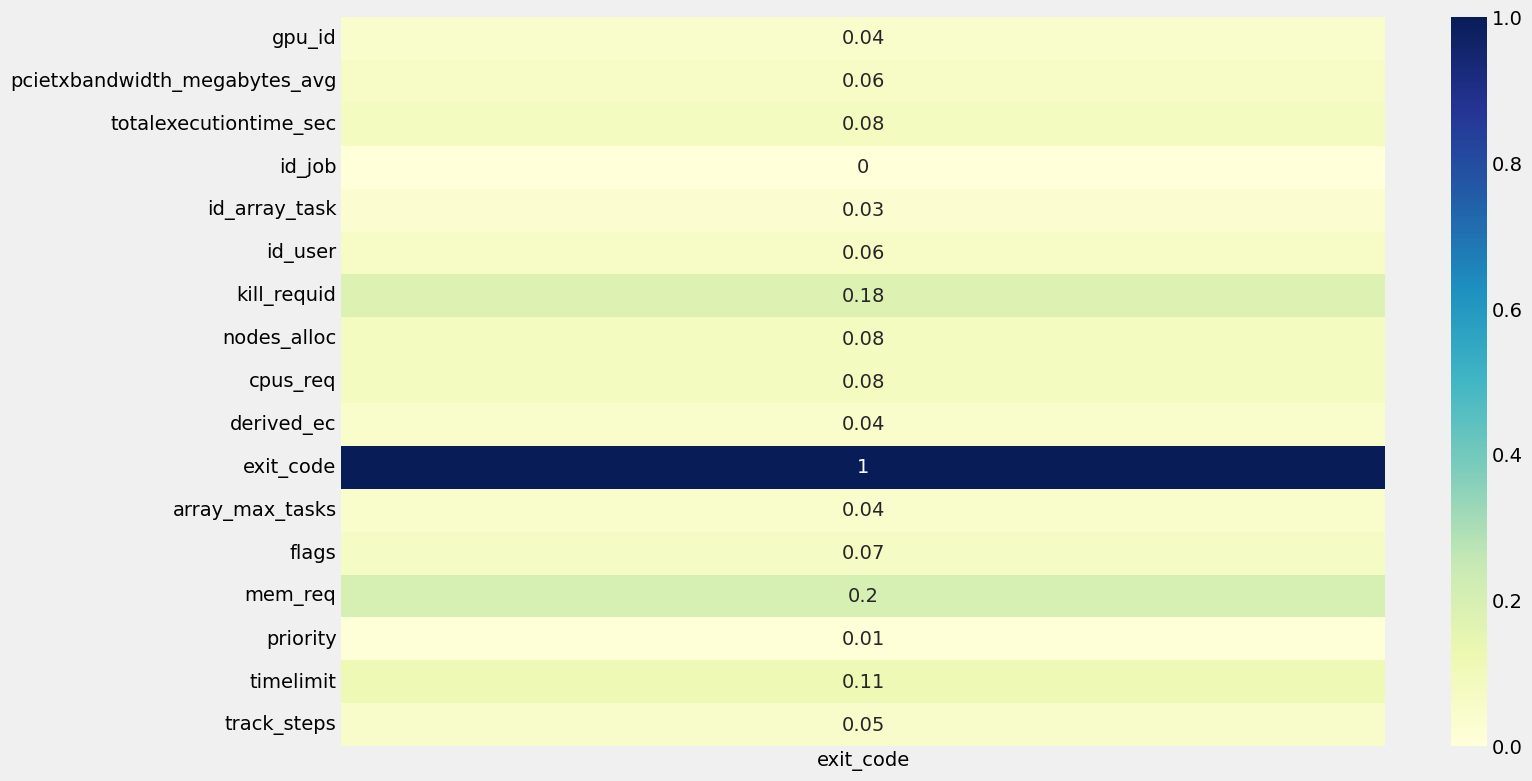

In [578]:
sns.heatmap(np.abs(merged_df.corr()[['exit_code']]).round(2), annot=True,  cmap="YlGnBu");

In [579]:
## Drop the features, that has very low correaltion

features_to_drop = ['gpu_id', 'priority','pcietxbandwidth_megabytes_avg',
                   'id_array_task', 'id_user', 'derived_ec', 'array_max_tasks', 'track_steps', 
                   'id_job']
## Notice that totalexecutiontime_sec is also low correlation, but not in dropped columns. 
merged_df.drop(features_to_drop, axis=1, inplace=True, errors='ignore')
merged_df.shape

(96805, 12)

In [580]:
merged_df.duplicated().sum()

39761

In [581]:
merged_df.drop_duplicates(inplace=True)

# Final data prep for modeling

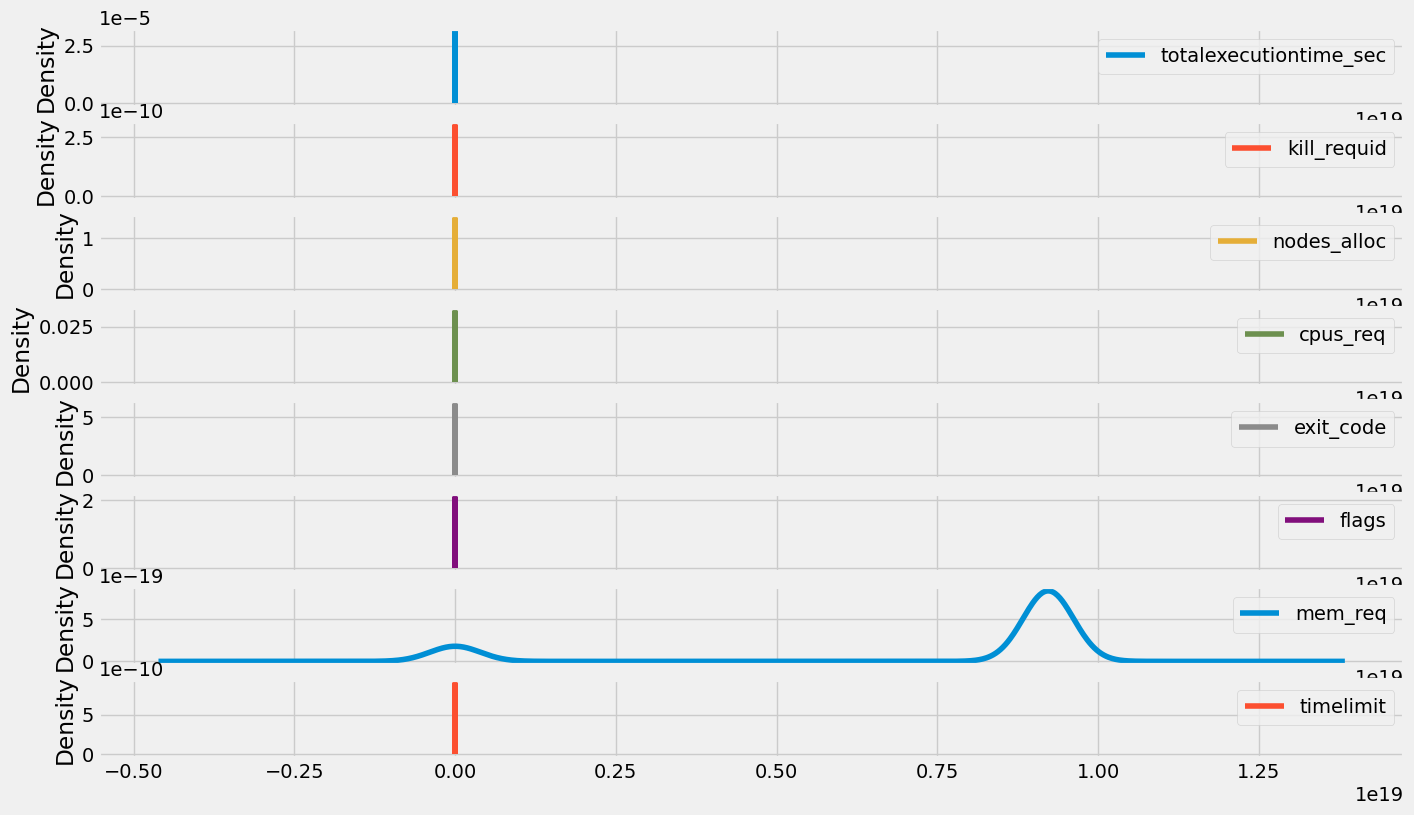

In [582]:
merged_df.plot(kind = 'kde', subplots = True);

## Prepare Categorical Data

In [583]:
merged_df_dummy = pd.get_dummies(merged_df, drop_first=True)
merged_df_dummy.head()

,totalexecutiontime_sec,kill_requid,nodes_alloc,cpus_req,exit_code,flags,mem_req,timelimit,gres_req_10,gres_req_12,...,gres_alloc_4,gres_alloc_5,gres_alloc_6,gres_alloc_64,gres_alloc_8,partition_normal,partition_test,job_type_INTERACTIVE,job_type_MAP,job_type_OTHER
0,4452.47,8153593386,1,20,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.54,51671871839,1,10,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,1
2,8398.30,51671871839,1,1,1,2,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1851.72,8153593386,1,20,0,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.99,51671871839,1,10,1,4,9223372036854784308,4294967295,0,0,...,0,0,0,0,0,1,0,0,0,1


In [584]:
merged_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57044 entries, 0 to 96804
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   totalexecutiontime_sec  57044 non-null  float64
 1   kill_requid             57044 non-null  int64  
 2   nodes_alloc             57044 non-null  int64  
 3   cpus_req                57044 non-null  int64  
 4   exit_code               57044 non-null  int64  
 5   flags                   57044 non-null  int64  
 6   mem_req                 57044 non-null  uint64 
 7   timelimit               57044 non-null  int64  
 8   gres_req_10             57044 non-null  uint8  
 9   gres_req_12             57044 non-null  uint8  
 10  gres_req_16             57044 non-null  uint8  
 11  gres_req_2              57044 non-null  uint8  
 12  gres_req_3              57044 non-null  uint8  
 13  gres_req_32             57044 non-null  uint8  
 14  gres_req_4              57044 non-null

In [585]:
merged_df.exit_code.value_counts()

0    42276
1    14768
Name: exit_code, dtype: int64

# Test Train Split

In [586]:
#splitting the data
X = merged_df_dummy.drop(columns='exit_code').copy()
y = merged_df['exit_code']

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2)

print(X_train.shape)
print(X_test.shape)

(42783, 34)
(14261, 34)


## Scale the data

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
      

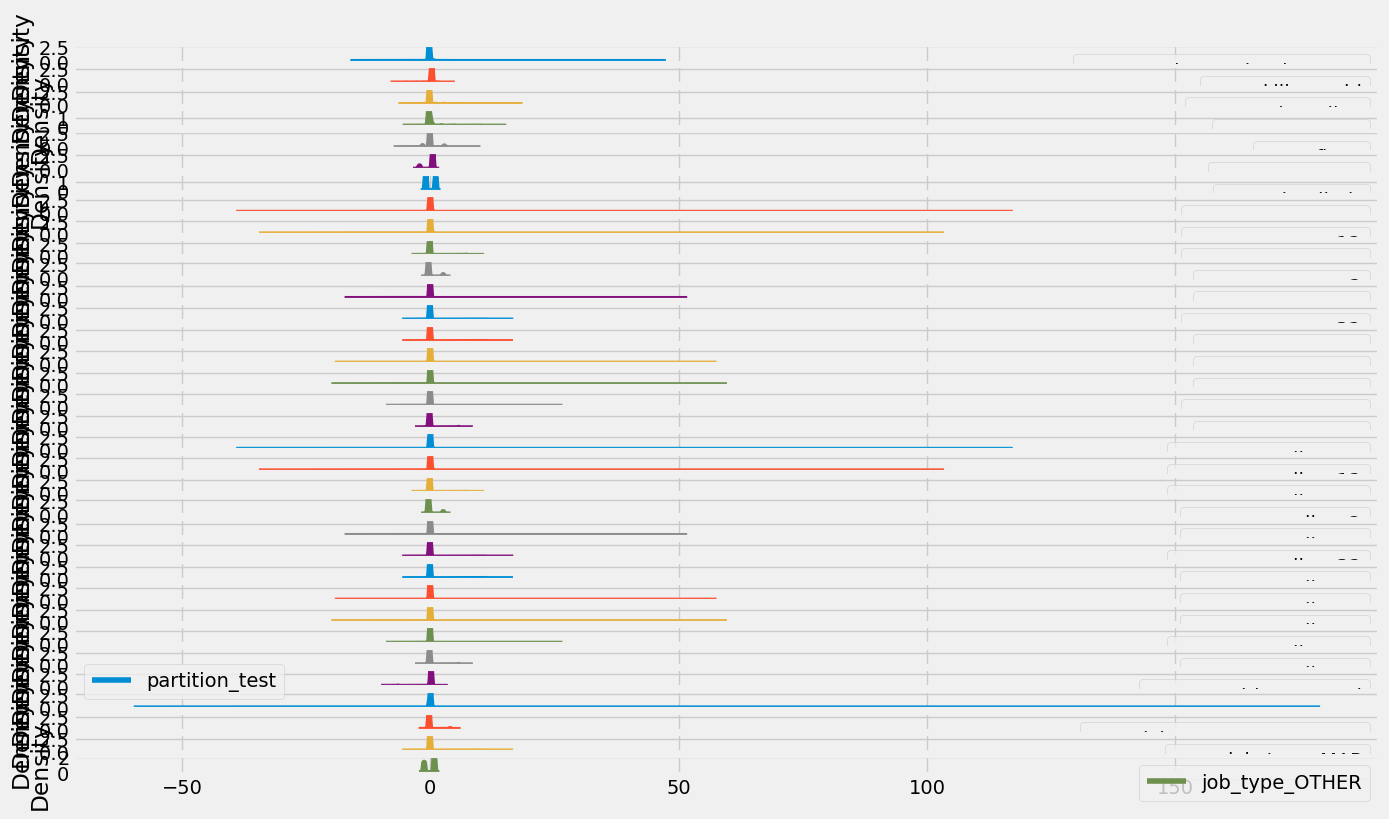

In [587]:
scaler = StandardScaler()
numCol = X_train.select_dtypes(np.number).columns.to_list()
train_scaled = X_train.copy()
train_scaled[numCol] = scaler.fit_transform(X_train[numCol])

test_scaled = X_test.copy()
test_scaled[numCol] = scaler.transform(X_test[numCol])

# Create kde Plot for scaled data
train_scaled.plot(kind = 'kde', subplots = True)


# Modeling

## Find Significant Features using Logistic Regression

**TODO: 1) Find out why there is a difference in coef using selector vs no-selector
         2) Find out why selector chose only 3, instead of 10 features**

**DO NOT USE: for future**
pipeline = Pipeline([('scale', StandardScaler()),
                     ('selector', SelectFromModel(LogisticRegression(random_state=42), max_features=10)),
                     ('regres', LogisticRegression(random_state=42))])

pipeline.fit(X_train, y_train)

lr_coef = pipeline.named_steps['regres'].coef_
print(lr_coef)
print(pipeline.named_steps['selector'].get_support())
feature_names_lr = np.array(X_train.columns.tolist())
#print(feature_names)
#print(len(pipeline.named_steps['tranform'].get_feature_names_out()))

print(feature_names_lr[pipeline.named_steps['selector'].get_support()])

In [588]:
pipeline2 = Pipeline([('scale', StandardScaler()),
                     ('regres', LogisticRegression(random_state=42))])

pipeline2.fit(train_scale, y_train)

lr_coef2 = pipeline2.named_steps['regres'].coef_[0]
feature_names2 = train_scale.columns.tolist()
lr_feature_df2 = pd.DataFrame({'feature': feature_names2, 'coef': np.abs(lr_coef2)})
lr_feature_df2.loc[lr_feature_df2['coef'] != 0]
lr_feature_df2.nlargest(n=10, columns='coef')


NameError: name 'train_scale' is not defined

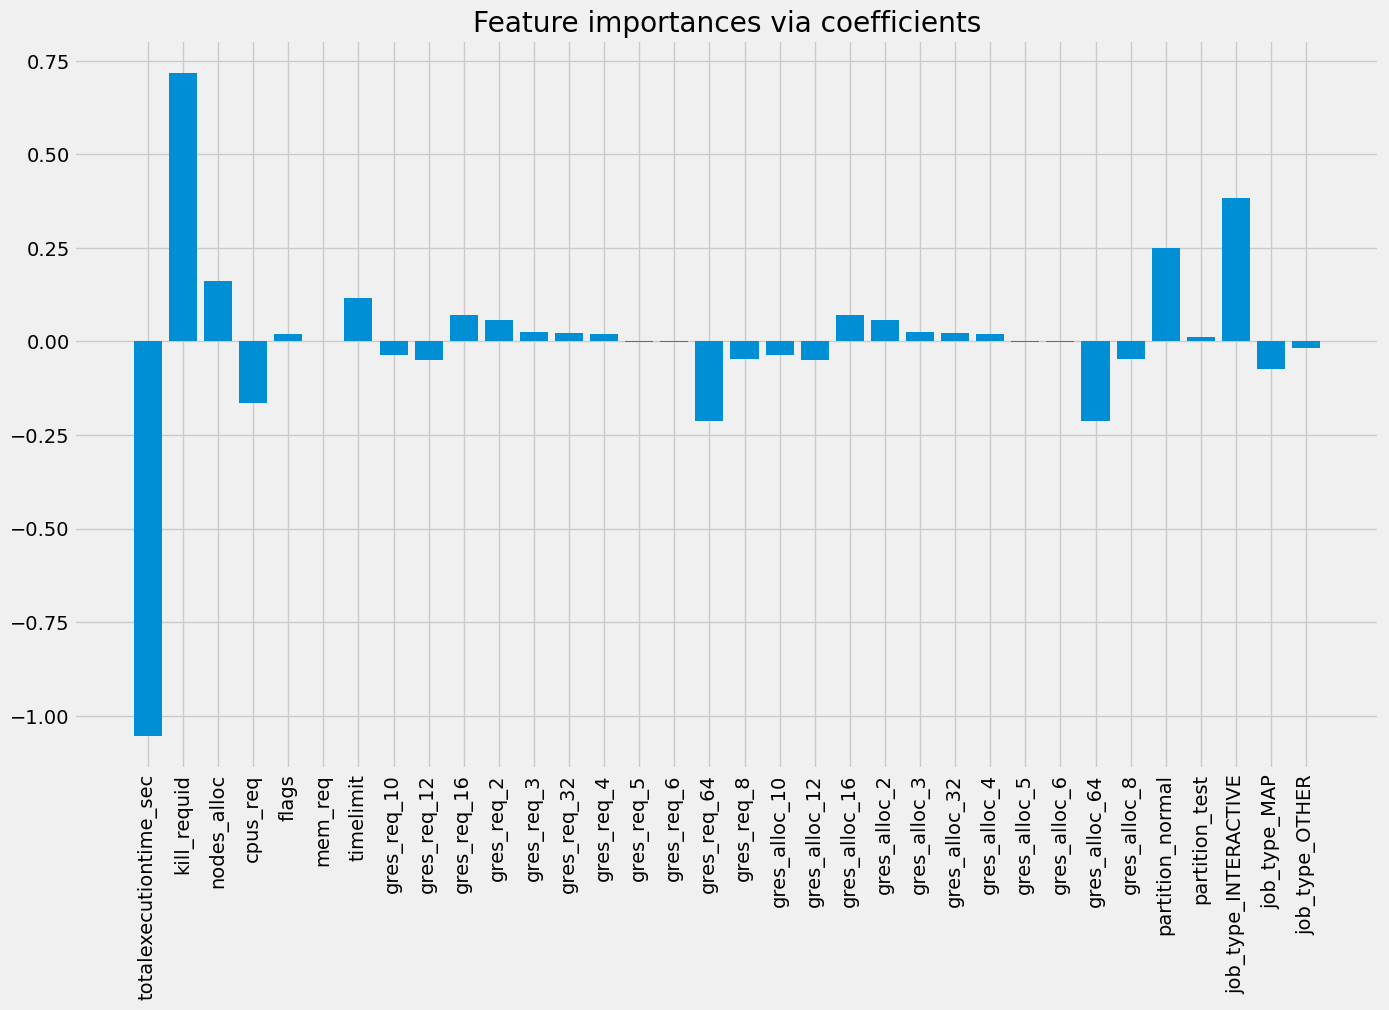

In [589]:
plt.bar(height=lr_coef2, x=feature_names2)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

### Train Test split with 10 most importance features

In [590]:
X_train, X_test, y_train, y_test = train_test_split(X[lr_feature_df2.nlargest(n=10, columns='coef')['feature']], y)

print(X_train.shape, X_test.shape)
X_train.head()

(42783, 10) (14261, 10)


,totalexecutiontime_sec,kill_requid,job_type_INTERACTIVE,partition_normal,gres_req_64,gres_alloc_64,cpus_req,nodes_alloc,timelimit,job_type_MAP
17813,68.28,51671871839,0,1,0,0,1,1,1440,0
65280,21.59,1539197275,0,1,0,0,320,8,30240,0
49171,2395.55,51671871839,0,1,0,0,16,1,4320,0
40029,0.30,51671871839,0,1,0,0,10,1,21600,0
71832,21346.20,51671871839,0,1,0,0,40,1,525600,0


## Apply Various models and compare the performances

### Create Dataframe to capture performances of various models

In [591]:
res_dict = {'model': [],
           'train score': [],
           'test score': [],
           'average fit time': []}
df_results = pd.DataFrame(res_dict)
df_results.head()

,model,train score,test score,average fit time


In [592]:
models = [KNeighborsClassifier(), LogisticRegression(random_state=42), 
          DecisionTreeClassifier(random_state=42), SVC(random_state=42),RandomForestClassifier(random_state=42)
         ]

for m in models:
    t1 = time.time()
    model = m
    model.fit(X_train, y_train)
    fit_time = time.time() - t1
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    df_results.loc[len(df_results.index)] = [m, train_score,test_score,fit_time ]

df_results.set_index('model')
df_results.head()

,model,train score,test score,average fit time
0,KNeighborsClassifier(),0.900077,0.861090,0.043404
1,LogisticRegression(random_state=42),0.740832,0.741954,0.051947
2,DecisionTreeClassifier(random_state=42),0.991328,0.866910,0.089427
3,SVC(random_state=42),0.740832,0.741954,37.098638


### CONCLUSION
**Best Model: KN Classifier**
- DecisionTree although generates highest score, it seems to be overfitting
- SVC model's average fit_time is very high, and the score is poor even though test score is very close to train score
- KN Classifier is the best performing in terms of fit time and accuracy score

## Confusion Matrix Using KN Classifier

### KN Classifier Model Predictions 

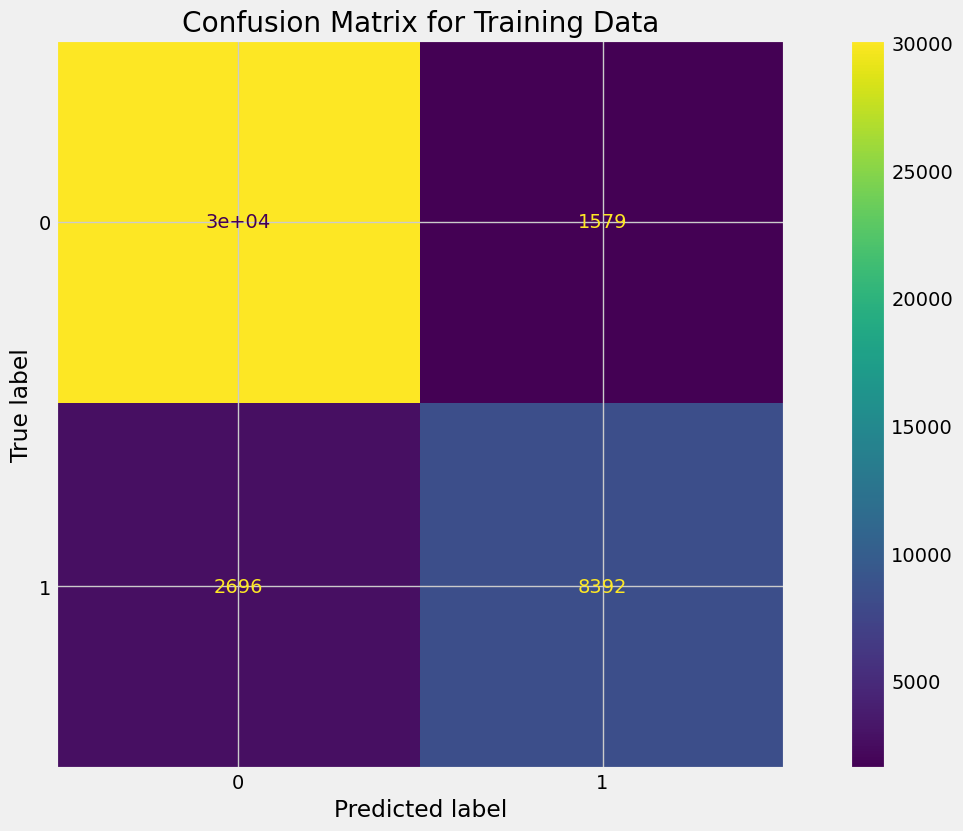

In [593]:
# Create KNeighbors Classifier
knc = KNeighborsClassifier().fit(X_train, y_train)

#prediction on training set
train_pred = knc.predict(X_train)

# confusion Matrix
cm = confusion_matrix(y_train, train_pred, labels = knc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels= knc.classes_)

# show the plot
disp.plot()
plt.title('Confusion Matrix for Training Data')
plt.show()


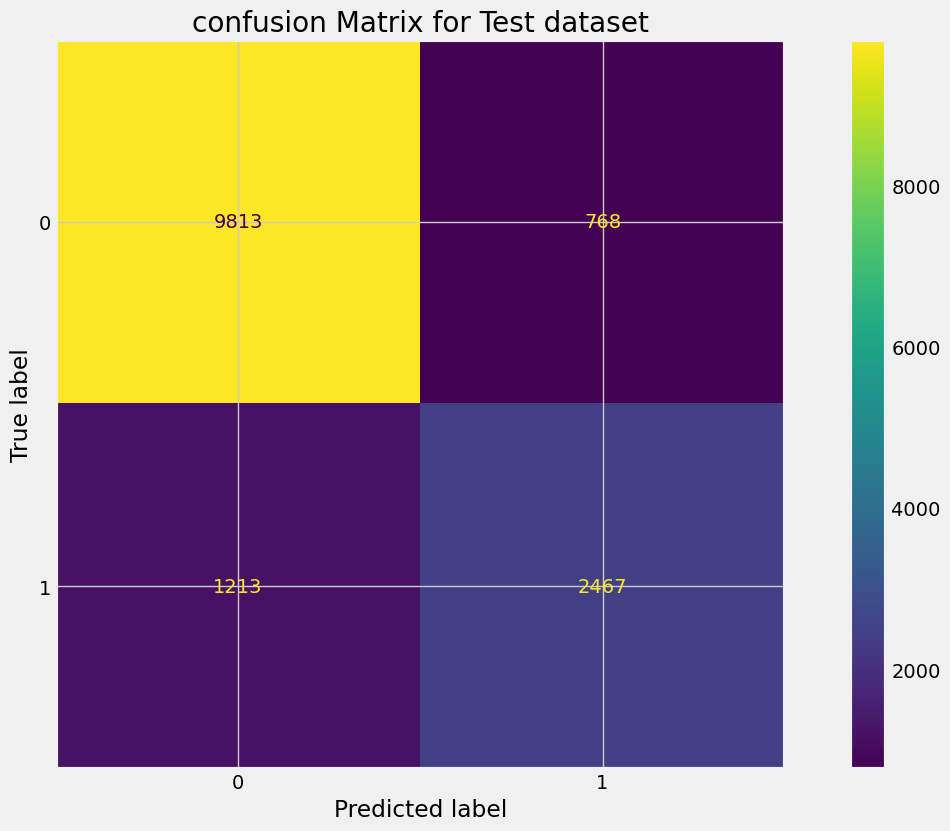

In [594]:
test_pred = knc.predict(X_test)

# confusion Matrix
cm = confusion_matrix(y_test, test_pred, labels = knc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix= cm,display_labels= knc.classes_)

# show the plot
disp.plot()
plt.title("confusion Matrix for Test dataset")
plt.show()



## Get KN Classifiers features 

In [595]:
print(knc.effective_metric_)
print(knc.feature_names_in_)
print(knc.get_params())

euclidean
['totalexecutiontime_sec' 'kill_requid' 'job_type_INTERACTIVE'
 'partition_normal' 'gres_req_64' 'gres_alloc_64' 'cpus_req' 'nodes_alloc'
 'timelimit' 'job_type_MAP']
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


# Conclusion

**Summary**: DecisionTree gave 100% accurate results based on the state, that create questions about the model and overfitting it. 
Looking further into it, one can understand that "state" will not be present for future jobs. State also indicate if Job was successful or not, hence such high correlation with exit_code.

**Error In the Model**:  State is not available for any of the future jobs, so it should have been removed from the data set. Same applies to time_start, time_end etc. All these columns should be dropped before applying the models on it. 
Since "state" is the simply the details related to job exit code, it's also target column and hence should have been removed

# TODO
- adjust false-positives, false-negatives as per the problem
- Add Random Forest and XGBoost to the list of models to compare performance and try again
- Clean up the code
- Remove the first logistic regression, as this is causing rest of the models to work against a linearly biased model's results
